In [218]:
 pip install --upgrade pip

In [219]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [220]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [221]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [222]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [223]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [224]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    EX_PATH = os.path.join('lfw', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [225]:
import uuid

In [226]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\9a44e70b-0157-11ef-91bf-5405dbe7dbeb.jpg'

In [113]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    if cv2.waitKey(1) & 0XFF == ord('a'):
         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
         cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
          imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
          cv2.imwrite(imgname, frame)
         
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
         break
cap.release()
cv2.destroyAllWindows()

In [227]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [228]:
dir_test = anchor.as_numpy_iterator()

In [229]:
dir_test.next()

b'data\\anchor\\Andre_Agassi_0025.jpg'

In [230]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img
               

In [231]:
img = preprocess("C:\\Users\\BALRAM SINGH\\Pictures\\Dataset\\data\\anchor\\kane_(45).jpg")


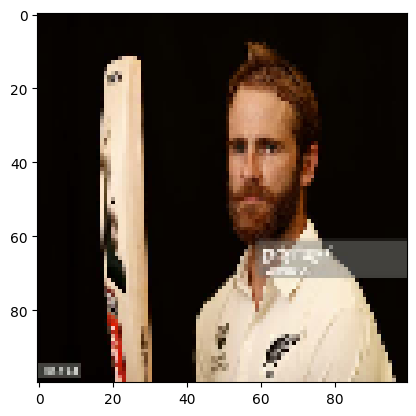

In [232]:
plt.imshow(img)

In [233]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [234]:
positives= tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [235]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [236]:
samples = data.as_numpy_iterator()

In [237]:
exampple = samples.next()

In [238]:
exampple

(b'data\\anchor\\Amelie_Mauresmo_0015.jpg',
 b'data\\positive\\Amelie_Mauresmo_0006.jpg',
 1.0)

In [239]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [240]:
res = preprocess_twin(*exampple)

In [241]:
len(res)

3

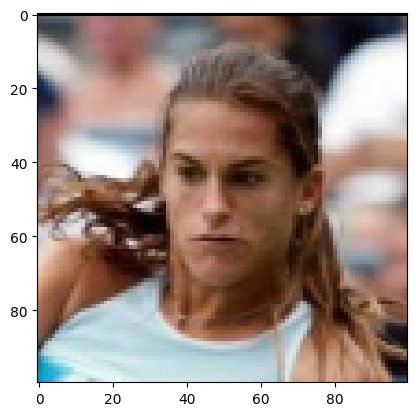

In [242]:
plt.imshow(res[1])

In [243]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [244]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [245]:
samples = data.as_numpy_iterator()

In [246]:
len(samples.next())

3

In [247]:
samp  = samples.next()

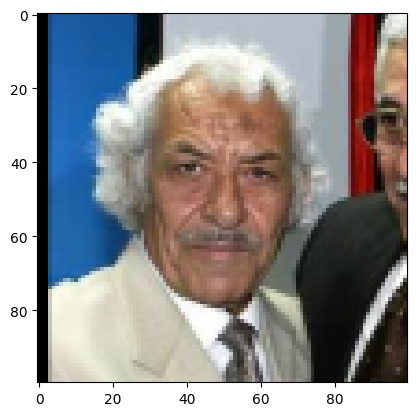

In [248]:
plt.imshow(samp[1])

In [249]:
samp[1]

array([[[0.        , 0.00392157, 0.        ],
        [0.00294118, 0.        , 0.00588235],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.9362745 , 0.9558824 , 0.9284314 ],
        [0.95980394, 0.9794118 , 0.9519608 ],
        [0.9502451 , 0.9698529 , 0.94240195]],

       [[0.        , 0.00392157, 0.        ],
        [0.00294118, 0.        , 0.00588235],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.94240195, 0.9620098 , 0.9345588 ],
        [0.9529412 , 0.972549  , 0.94509804],
        [0.9117647 , 0.9313725 , 0.90392154]],

       [[0.        , 0.00392157, 0.        ],
        [0.00294118, 0.        , 0.00588235],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.90416664, 0.9237745 , 0.8963235 ],
        [0.92720586, 0.9468137 , 0.9193627 ],
        [0.90367645, 0.9232843 , 0.8958333 ]],

       ...,

       [[0.        , 0.00392157, 0.        ],
        [0.        , 0.        , 0.00588235],
        [0.00294118, 0

In [250]:
samp[2]

0.0

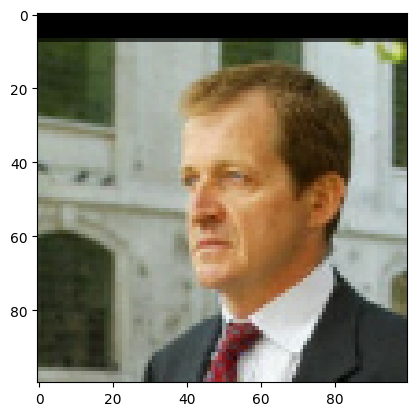

In [251]:
plt.imshow(samp[0])

In [252]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [253]:
round(len(data)*.7)

420

In [254]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [255]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [256]:
train_samples = train_data.as_numpy_iterator()

In [257]:
train_sample = train_samples.next()

In [258]:
len(train_sample[0])

16

In [259]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [260]:
inp = Input(shape=(100,100,3), name='input_image')

In [261]:
 c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [262]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_16')>

In [263]:
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [264]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d_12')>

In [265]:
 c2 = Conv2D(128, (7,7), activation='relu')(m1)
 m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [266]:
m2

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'max_pooling2d_13')>

In [267]:
 c3 = Conv2D(128, (4,4), activation='relu')(m2)
 m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [268]:
c3

<KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'conv2d_18')>

In [269]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_14')>

In [270]:
 c4 = Conv2D(256, (4,4), activation='relu')(m3)
 f1 = Flatten()(c4)
 d1 = Dense(4096, activation='sigmoid')(f1)

In [271]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_19')>

In [272]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten_4')>

In [273]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_6')>

In [274]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [275]:
mod

In [276]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 128)       26

In [277]:
def make_embedding():
     inp = Input(shape=(100,100,3), name='input_image')
     c1 = Conv2D(64, (10,10), activation='relu')(inp)
     m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
     c2 = Conv2D(128, (7,7), activation='relu')(m1)
     m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
     c3 = Conv2D(128, (4,4), activation='relu')(m2)
     m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
     c4 = Conv2D(256, (4,4), activation='relu')(m3)
     f1 = Flatten()(c4)
     d1 = Dense(4096, activation='sigmoid')(f1)
     return Model(inputs=[inp], outputs=[d1], name='embedding')

In [278]:
embedding = make_embedding()

In [279]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

In [280]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
         return tf.math.abs(input_embedding - validation_embedding)

In [281]:
l1 = L1Dist()

In [282]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [283]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [284]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [285]:
siamese_layer = L1Dist()

In [286]:
distances = siamese_layer(inp_embedding,val_embedding)

In [287]:
classifier = Dense(1, activation='sigmoid')(distances)

In [288]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_8')>

In [289]:
siamese_model =  Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [290]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [291]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = "distance" 
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [292]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [293]:
opt = tf.keras.optimizers.Adam(1e-4) 

In [294]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [295]:
test_batch = train_data.as_numpy_iterator()

In [296]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
         X = batch[:2]
         y = batch[2]
         yhat = siamese_model(X, training=True)
         loss = binary_cross_loss(y, yhat)
         grad = tape.gradient(loss, siamese_model.trainable_variables)
         opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
         return loss

In [297]:
from tensorflow.keras.metrics import Precision, Recall

In [298]:
import matplotlib.pyplot as plt
import numpy as np

def train(data, EPOCHS):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    train_precisions = []
    test_precisions = []

    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        
        # Compute metrics after each epoch
        train_loss = loss.numpy()
        train_accuracy = r.result().numpy()
        train_precision = p.result().numpy()
        
        # Print metrics after each epoch
        print("Epoch {} - Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training Precision: {:.4f}".format(
            epoch, train_loss, train_accuracy, train_precision))
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Plot the training losses
    epochs = np.arange(1, EPOCHS + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [299]:
EPOCHS = 100

In [300]:

train(train_data, EPOCHS)



 Epoch 1/100
27/27 [==============================] - 85s 3s/step
Epoch 1 - Training Loss: 0.6917, Training Accuracy: 0.7955, Training Precision: 0.5591

 Epoch 2/100
27/27 [==============================] - 78s 3s/step
Epoch 2 - Training Loss: 0.6754, Training Accuracy: 0.5120, Training Precision: 0.5515

 Epoch 3/100
27/27 [==============================] - 78s 3s/step
Epoch 3 - Training Loss: 0.6448, Training Accuracy: 0.8019, Training Precision: 0.5171

 Epoch 4/100
27/27 [==============================] - 81s 3s/step
Epoch 4 - Training Loss: 0.6801, Training Accuracy: 0.6056, Training Precision: 0.5489

 Epoch 5/100
27/27 [==============================] - 80s 3s/step
Epoch 5 - Training Loss: 0.7019, Training Accuracy: 0.6866, Training Precision: 0.5227

 Epoch 6/100
27/27 [==============================] - 78s 3s/step
Epoch 6 - Training Loss: 0.7092, Training Accuracy: 0.7286, Training Precision: 0.6000

 Epoch 7/100
27/27 [==============================] - 83s 3s/step
Epoch 7 -

KeyboardInterrupt: 

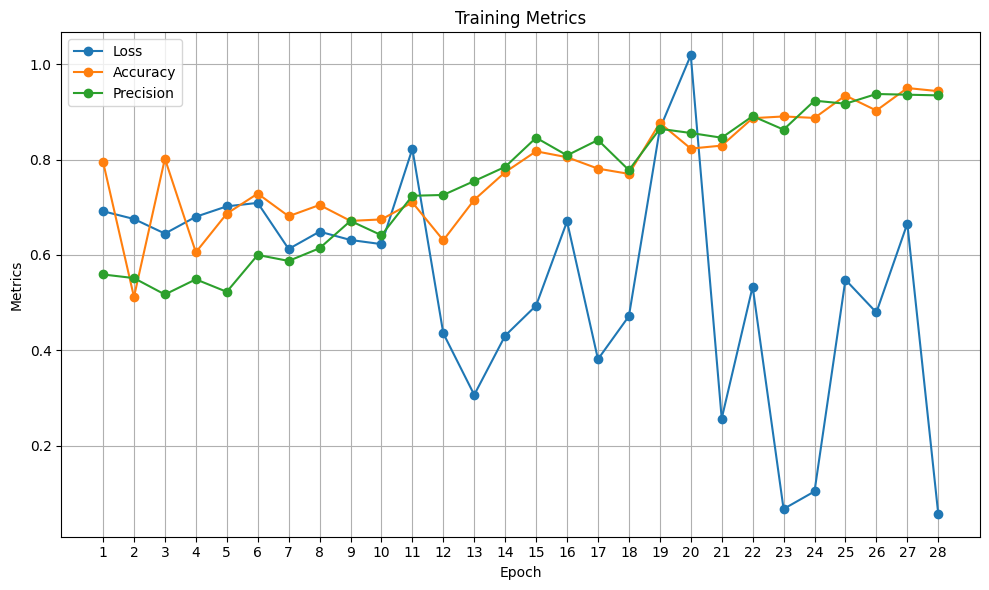

In [304]:
 import matplotlib.pyplot as plt

epochs = list(range(1, 29))  # Assuming 28 epochs

# Sample data for loss, accuracy, and precision
loss = [0.6917, 0.6754, 0.6448, 0.6801, 0.7019, 0.7092, 0.6125, 0.6489, 0.6314, 0.6227, 0.8224, 0.4356, 0.3067, 0.4308, 0.4939, 0.6703, 0.3814, 0.4717, 0.8645, 1.0187, 0.257, 0.5335, 0.0674, 0.1042, 0.5481, 0.4794, 0.6657, 0.0573]
accuracy = [0.7955, 0.512, 0.8019, 0.6056, 0.6866, 0.7286, 0.6812, 0.7048, 0.6714, 0.6745, 0.7101, 0.6308, 0.7156, 0.7736, 0.8173, 0.8049, 0.781, 0.77, 0.8768, 0.823, 0.8293, 0.8868, 0.8904, 0.8873, 0.9343, 0.9028, 0.95, 0.9434]
precision = [0.5591, 0.5515, 0.5171, 0.5489, 0.5227, 0.6, 0.5875, 0.6141, 0.6714, 0.6413, 0.7241, 0.7258, 0.755, 0.7847, 0.8458, 0.8088, 0.841, 0.7778, 0.8645, 0.8557, 0.8458, 0.891, 0.8628, 0.9235, 0.9171, 0.9375, 0.936, 0.9346]

# Plotting the graphs
plt.figure(figsize=(10, 6))

plt.plot(epochs, loss, label='Loss', marker='o')
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, precision, label='Precision', marker='o')

plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()

plt.show()


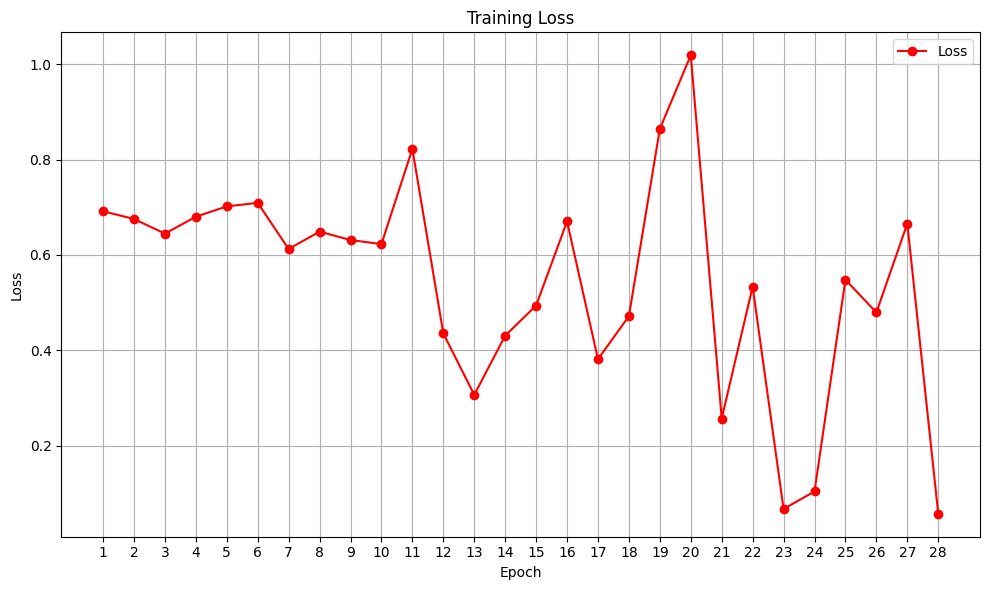

Final Loss: 0.0573


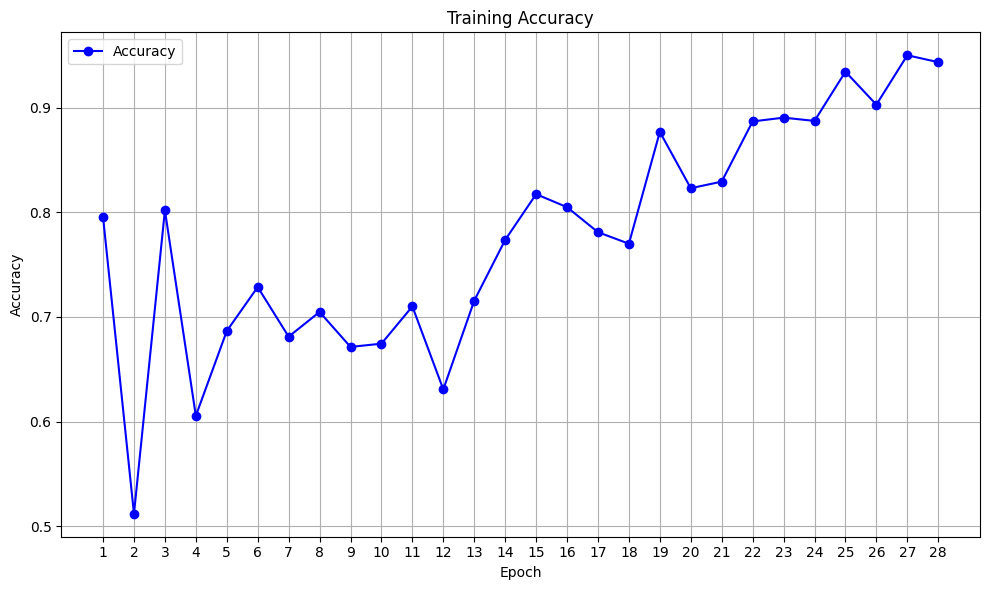

Final Accuracy: 0.9434


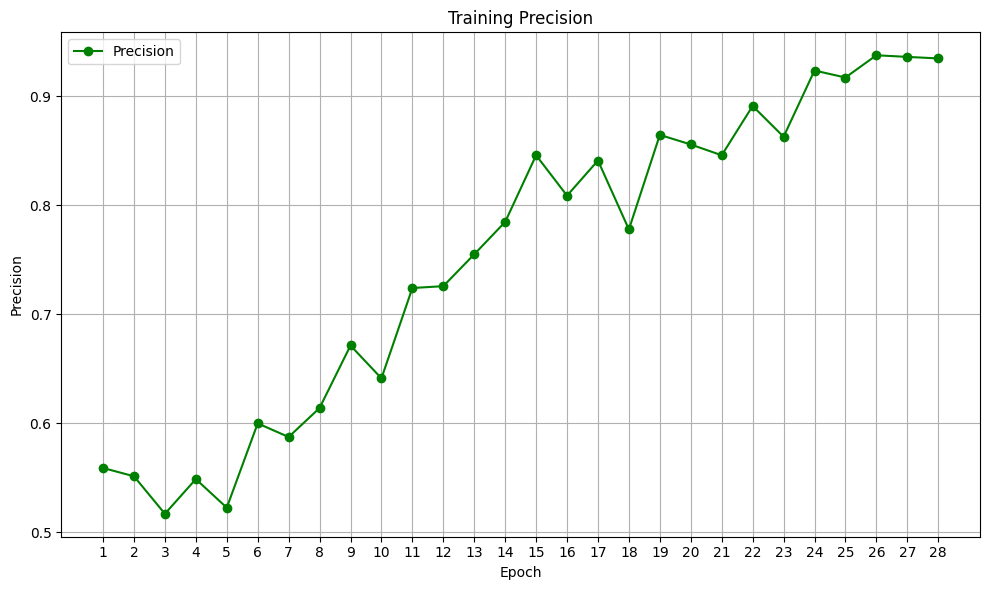

Final Precision: 0.9346


In [306]:
import matplotlib.pyplot as plt

epochs = list(range(1, 29))  # Assuming 28 epochs

# Sample data for loss, accuracy, and precision
loss = [0.6917, 0.6754, 0.6448, 0.6801, 0.7019, 0.7092, 0.6125, 0.6489, 0.6314, 0.6227, 0.8224, 0.4356, 0.3067, 0.4308, 0.4939, 0.6703, 0.3814, 0.4717, 0.8645, 1.0187, 0.257, 0.5335, 0.0674, 0.1042, 0.5481, 0.4794, 0.6657, 0.0573]
accuracy = [0.7955, 0.512, 0.8019, 0.6056, 0.6866, 0.7286, 0.6812, 0.7048, 0.6714, 0.6745, 0.7101, 0.6308, 0.7156, 0.7736, 0.8173, 0.8049, 0.781, 0.77, 0.8768, 0.823, 0.8293, 0.8868, 0.8904, 0.8873, 0.9343, 0.9028, 0.95, 0.9434]
precision = [0.5591, 0.5515, 0.5171, 0.5489, 0.5227, 0.6, 0.5875, 0.6141, 0.6714, 0.6413, 0.7241, 0.7258, 0.755, 0.7847, 0.8458, 0.8088, 0.841, 0.7778, 0.8645, 0.8557, 0.8458, 0.891, 0.8628, 0.9235, 0.9171, 0.9375, 0.936, 0.9346]

# Plotting Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Loss', marker='o', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

# Printing final loss
print("Final Loss:", loss[-1])

# Plotting Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Accuracy', marker='o', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

# Printing final accuracy
print("Final Accuracy:", accuracy[-1])

# Plotting Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, label='Precision', marker='o', color='green')
plt.title('Training Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

# Printing final precision
print("Final Precision:", precision[-1])


In [307]:
from tensorflow.keras.metrics import Precision, Recall

In [308]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [309]:
test_var = test_data.as_numpy_iterator().next()

In [310]:
len(test_var)

3

In [311]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 384ms/step


array([[9.8756480e-01],
       [1.7264625e-02],
       [4.6276219e-02],
       [9.7779387e-01],
       [7.7026528e-01],
       [1.2252492e-01],
       [9.9991566e-01],
       [9.8411089e-01],
       [2.8128290e-01],
       [9.9992740e-01],
       [1.9743629e-02],
       [4.5192880e-03],
       [7.6107040e-02],
       [8.5384748e-04],
       [8.8918328e-01],
       [9.6308017e-01]], dtype=float32)

In [312]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]

In [313]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [1]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()


NameError: name 'plt' is not defined